## Import data, set logging level

In [2]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

## Reading Epochs and preprocessing

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.resample(600).crop(0, None)
info = epochs.info

## Create a dataset containig epoched data

In [3]:
dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
del raw, epochs, epochs_list

## Split the dataset into train and test sets

In [3]:
dataset = read_epochs_dataset('../data/multimodal.pt')

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [40]:
class HilbertNet(BaseModel):

    def __init__(self, n_channels, n_latent, n_times, filter_size, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, groups=n_latent, padding='same')
        self.temp_conv_activation = nn.LeakyReLU(-1)
        self.env_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = self.temp_conv_activation(x)
        x = self.env_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [22]:
class FIRNet(BaseModel):

    def __init__(self, n_channels, n_latent, n_times, filter_size, pool_factor, n_outputs):
        super().__init__()
        self.pool_factor = pool_factor
        self.temp_conv = nn.Conv1d(n_channels, n_channels, kernel_size=filter_size, groups=n_channels, padding='same')
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x):
        x = self.temp_conv(x)
        x = self.unmixing_layer(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [6]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [24]:
model = HilbertNet(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7778   |    binary_accuracy_train:  0.5823   |    loss_val:  0.7606   |    binary_accuracy_val:  0.6252
Epoch 1:  loss_train:  0.7367   |    binary_accuracy_train:  0.7283   |    loss_val:  0.7154   |    binary_accuracy_val:  0.7482
Epoch 2:  loss_train:  0.6832   |    binary_accuracy_train:  0.8264   |    loss_val:  0.6560   |    binary_accuracy_val:  0.8331
Epoch 3:  loss_train:  0.6184   |    binary_accuracy_train:  0.8616   |    loss_val:  0.5895   |    binary_accuracy_val:  0.8646
Epoch 4:  loss_train:  0.5524   |    binary_accuracy_train:  0.8719   |    loss_val:  0.5304   |    binary_accuracy_val:  0.8701
Epoch 5:  loss_train:  0.5005   |    binary_accuracy_train:  0.8748   |    loss_val:  0.4935   |    binary_accuracy_val:  0.8743
Epoch 6:  loss_train:  0.4728   |    binary_accuracy_train:  0.8754   |    loss_val:  0.4804   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4646   |    binary_accuracy_train:  0.8752   |    loss_val:  0.4788   | 

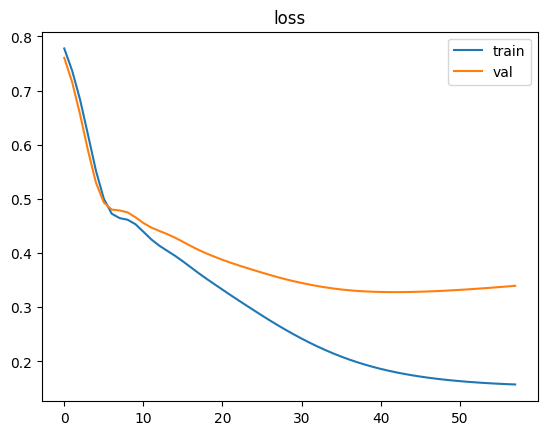

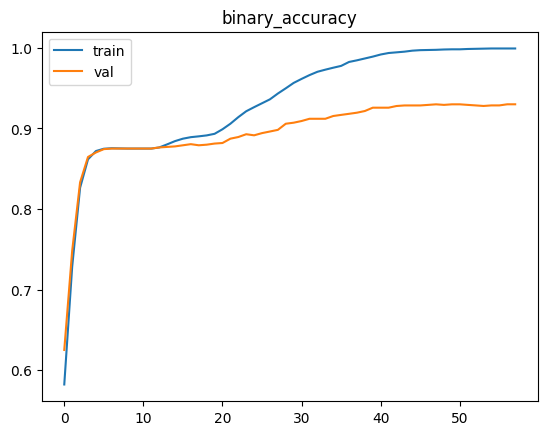

In [25]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [26]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.21100928295742383
train_binary_accuracy: 0.9800699244845997
loss: 0.3418743068521673
binary_accuracy: 0.9168019457296892


## Model interpretation

In [56]:
from deepmeg.interpreters import LFCNNInterpreter
from deepmeg.utils.viz import generate_cmap

class HilbertNetInterpreter(LFCNNInterpreter):
    """
        Initialize LFCNNInterpreter object.

        Parameters:
            model (LFCNN): Trained LFCNN model.
            dataset (Dataset): Data used to train the LFCNN model.
            info (mne.Info): Information about recordings, typically contained in the "info" property of the corresponding instance (E.g. epochs.info).

        """
    def __init__(self, model: HilbertNet, dataset: Dataset, info: mne.Info):
        super().__init__(model, dataset, info)
        self._envelopes = None

    @property
    @torch.no_grad()
    def envelopes(self):
        """
        Get the latent sources envelopes.

        Returns:
            torch.Tensor: The latent sources envelopes with shape (n_epochs, n_latent, n_times).
        """
        if self._envelopes is None:
            x = self.model.temp_conv_activation(torch.Tensor(self.latent_sources_filtered))
            x = self.model.temp_conv_activation(x)
            self._envelopes = self.model.env_conv(x).numpy()
        return self._envelopes

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:
        """
        Plot the branchwise information for a specific branch of the model.

        Parameters:
        branch_num (int): the branch number to plot (order of branches is determined by `branchwise_loss`).
        spec_plot_elems (List[str]): a list of plot elements to include in the spectrum plot.
        title (str): optional title for the plot.

        Returns:
        matplotlib.figure.Figure: the plot.

        """
        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        envelopes_sorted = self.envelopes[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.linspace(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], latent_sources_filt_sorted.shape[-1])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=0.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1.5,
            alpha=.5
        )
        ax2.plot(
            times,
            sp.stats.zscore(envelopes_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['spatially filtered', 'temporally filtered', 'envelope'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        plt.xlim(0, 100)
        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax3.plot(
                x,
                interp_cubic(data),
                alpha=.75,
                linestyle='--',
                color='tab:red'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax3.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax3.legend(spec_legend, loc='upper right')
        ax3.set_ylabel('Amplitude, zscore')
        ax3.set_xlabel('Frequency, Hz')
        ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap=generate_cmap(
                '#1f77b4',
                '#ffffff',
                '#d62728'
            )
        )
        if title:
            fig.suptitle(f'Branch {branch_num}')

        fig.tight_layout()

        return fig


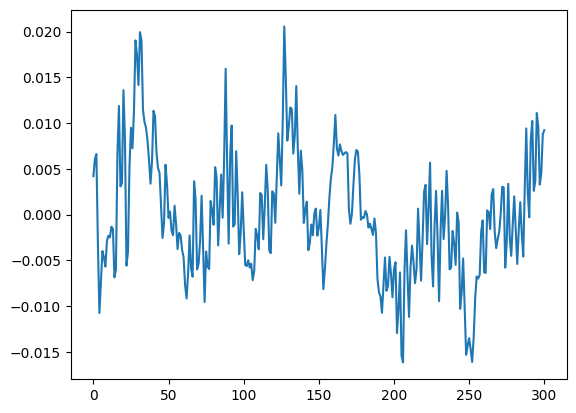

In [66]:
x, _ = next(iter(DataLoader(test, len(test))))
plt.plot(x.mean((0, 1)))

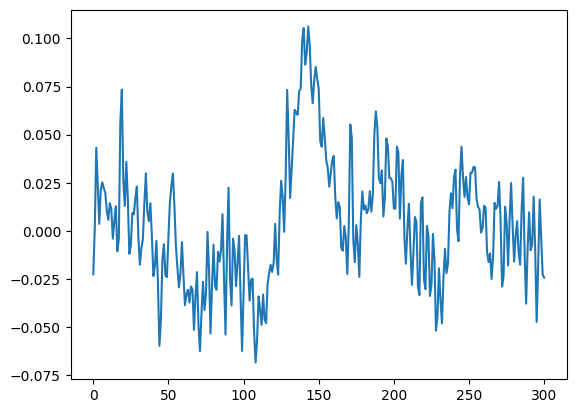

In [67]:
x = model.unmixing_layer(x)
plt.plot(x.detach().numpy().mean((0, 1)))

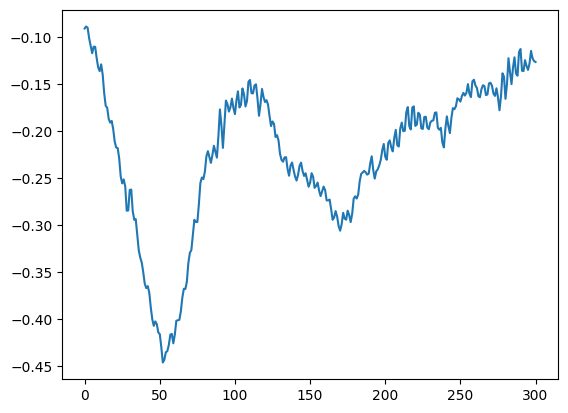

In [68]:
x = model.temp_conv(x)
plt.plot(x.detach().numpy().mean((0, 1)))

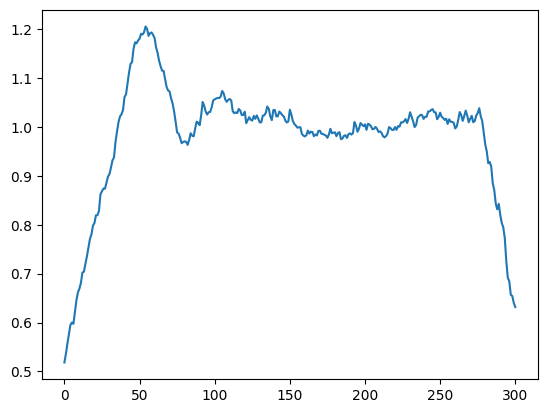

In [69]:
x = model.temp_conv_activation(x)
plt.plot(x.detach().numpy().mean((0, 1)))

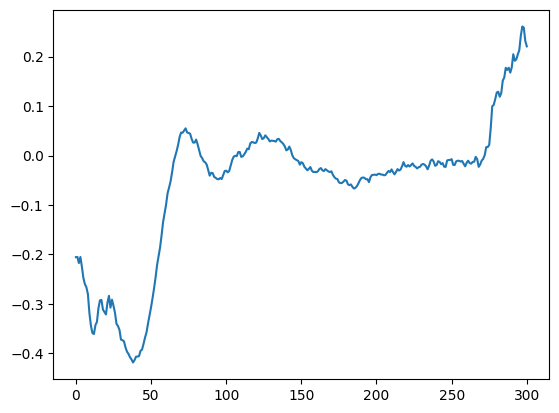

In [70]:
x = model.env_conv(x)
plt.plot(x.detach().numpy().mean((0, 1)))

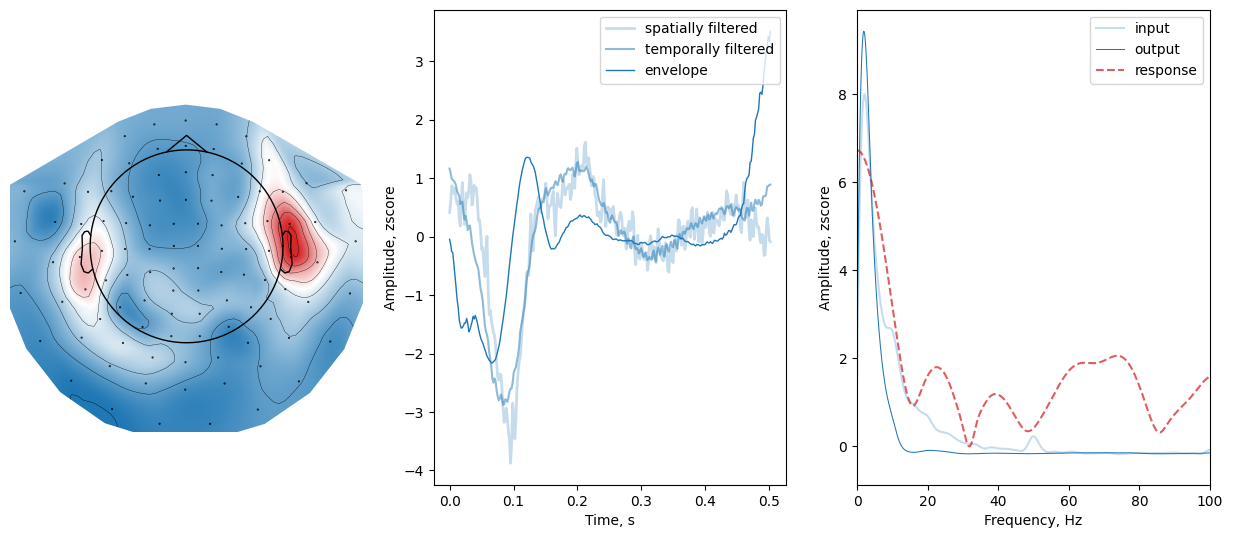

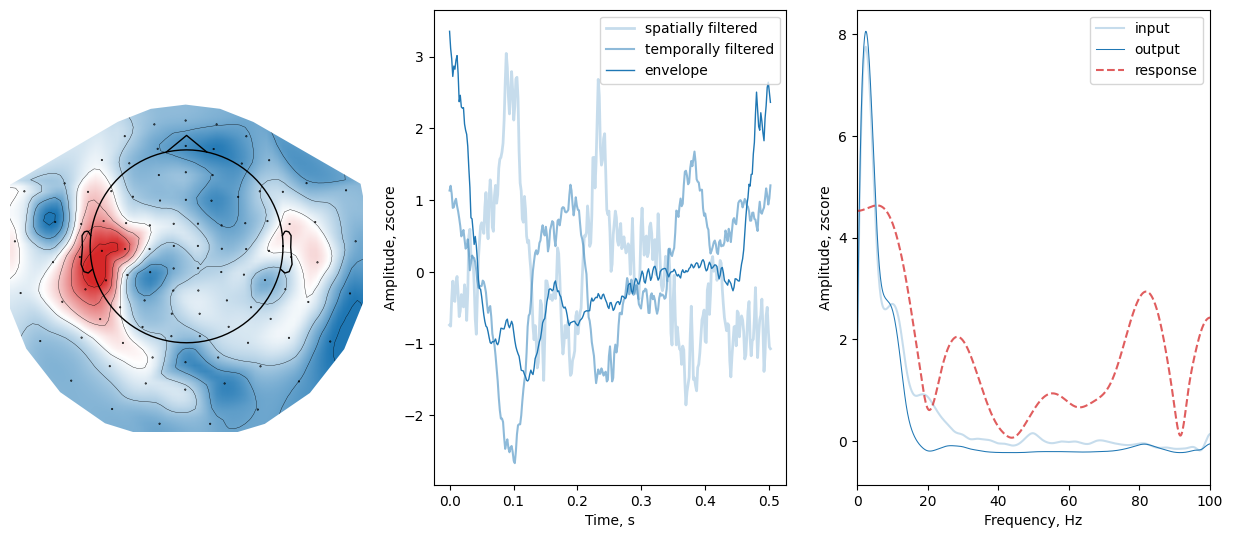

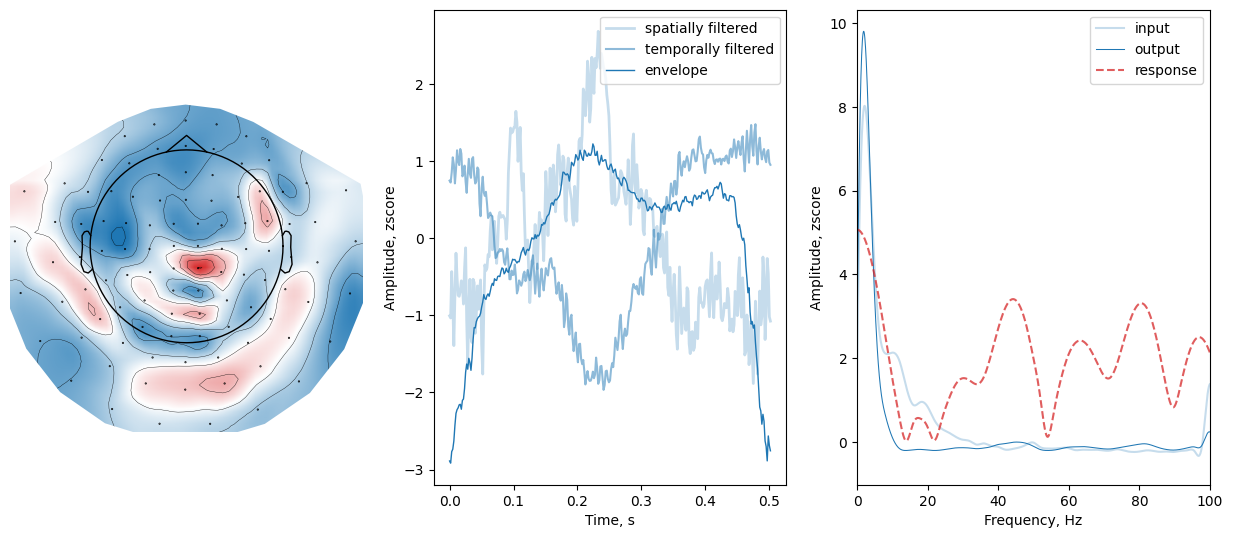

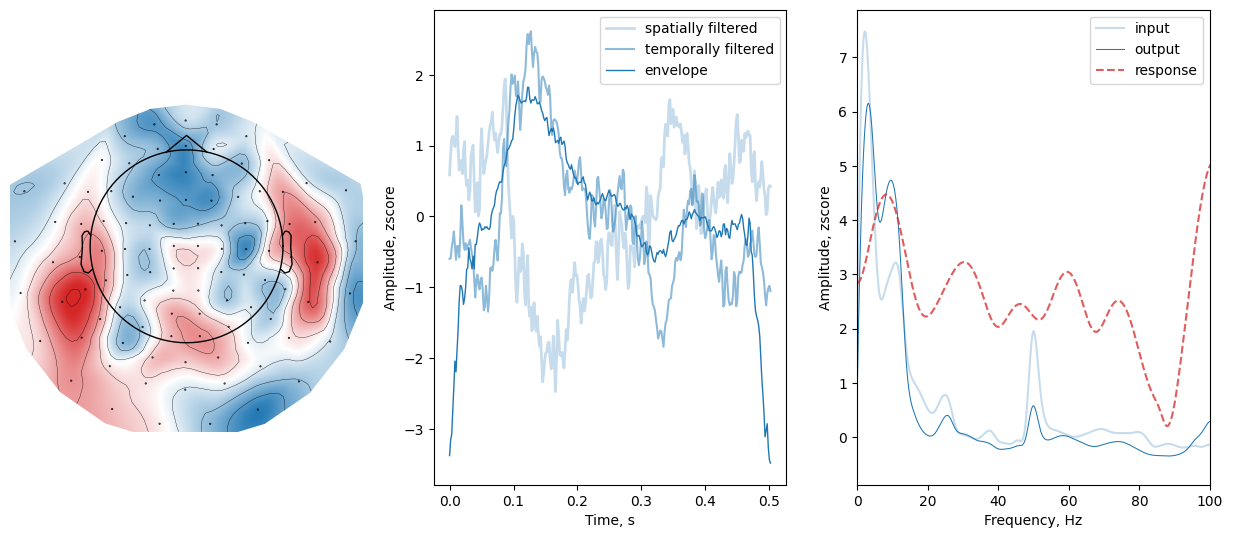

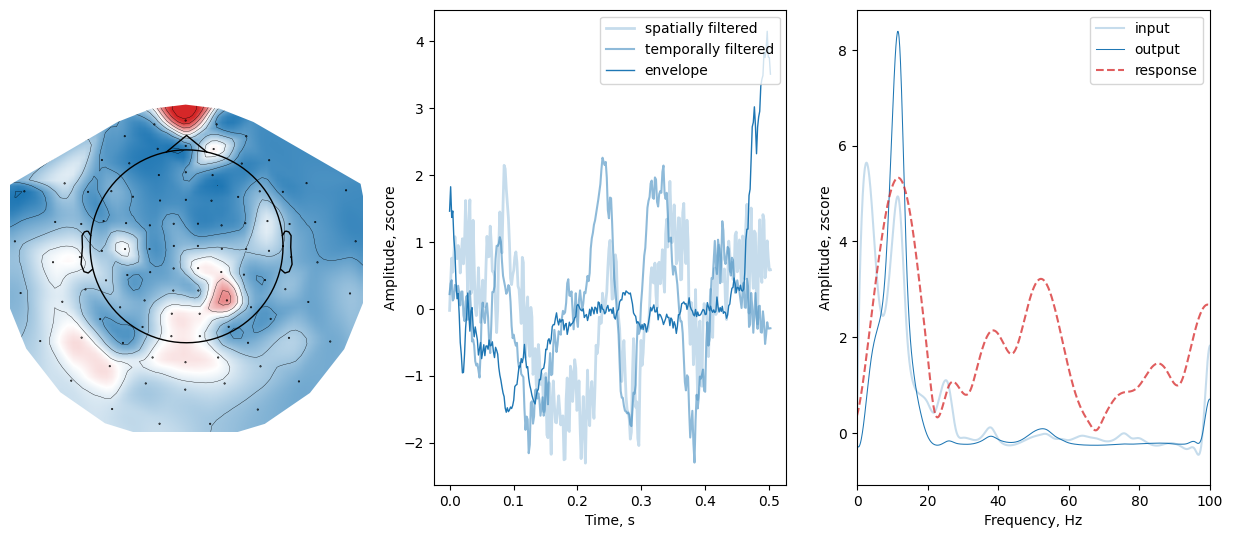

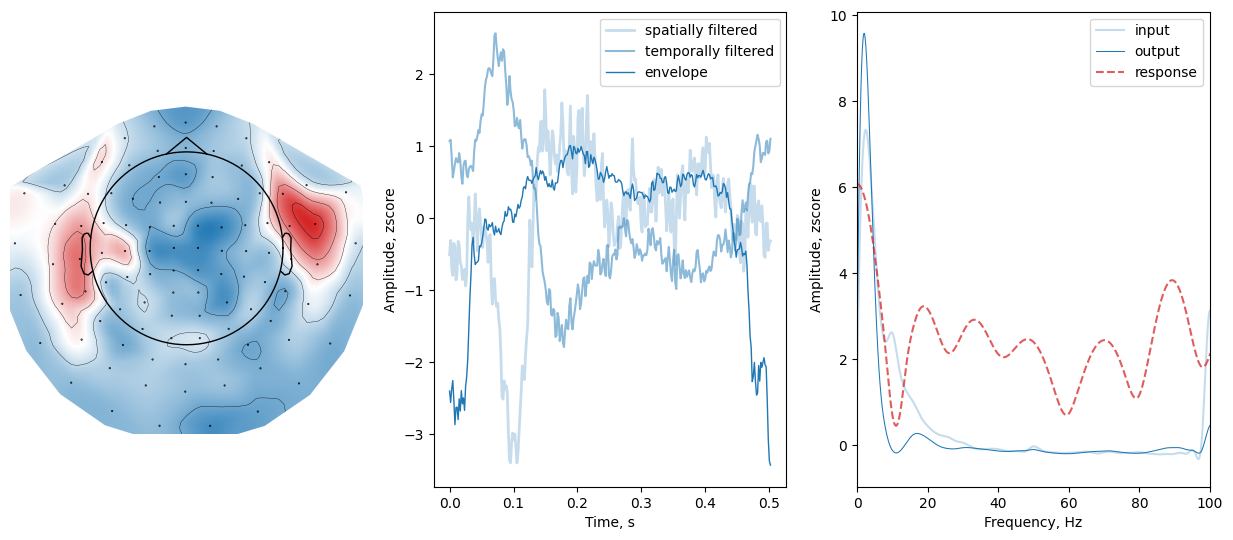

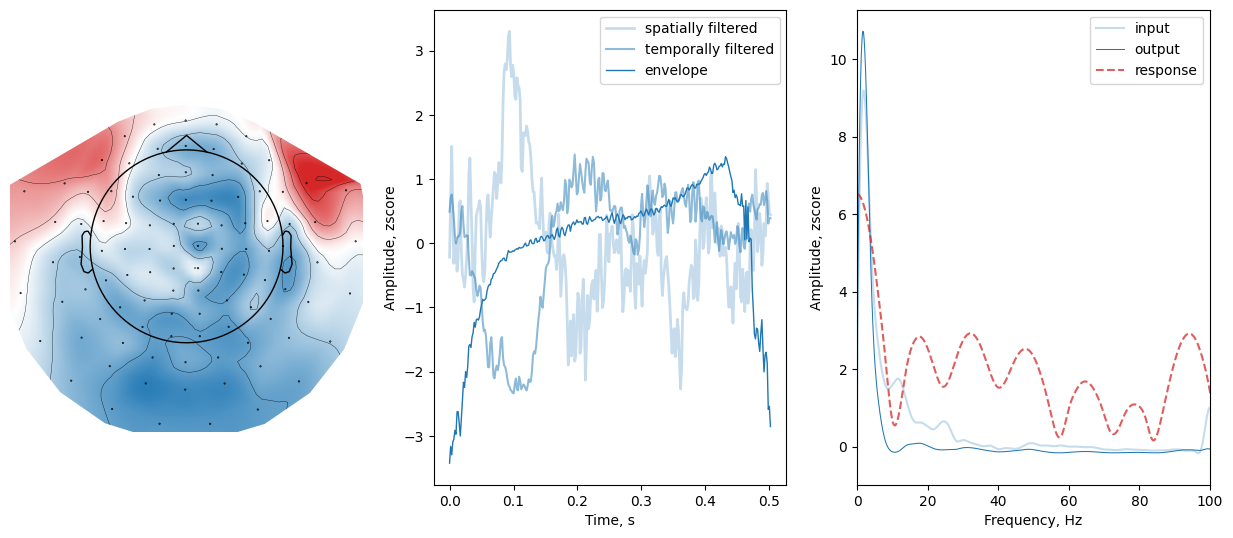

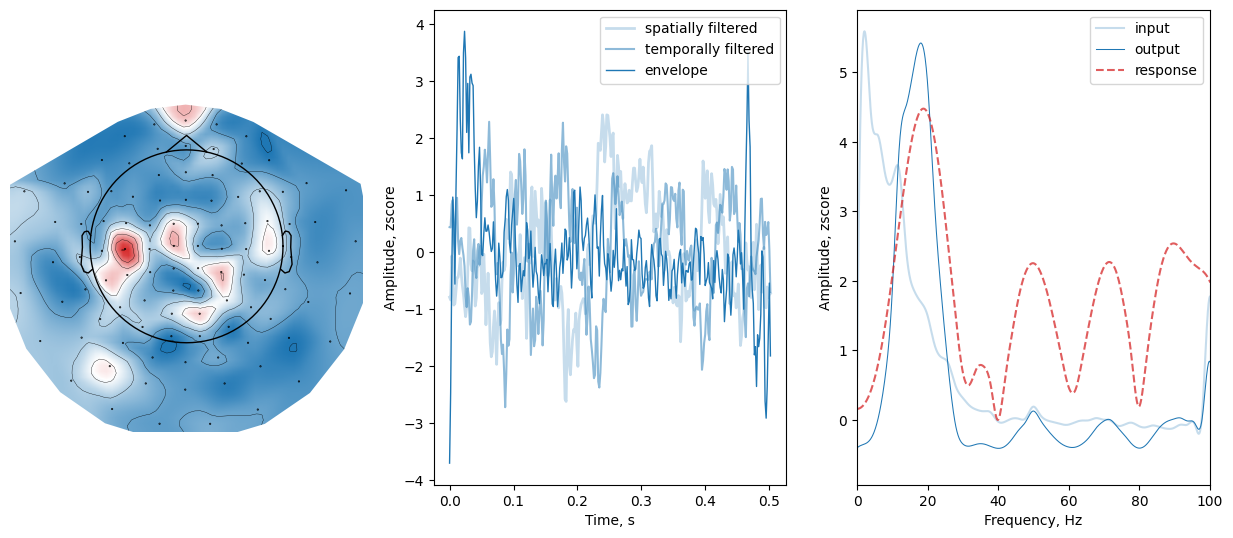

In [72]:
interpreter = HilbertNetInterpreter(model, test, info)
for i in range(8):
    fig = interpreter.plot_branch(i)
    plt.show()